# Deep Learning (Foundations): Course Project

**University:** NOVA Information Management School<br/>
**Program:** Master’s Degree Program in Data Science and Advanced Analytics<br/>
**Academic Year:** 2022/2023

```
============== Students: ==============
Iryna Savchuk (m20211310@novaims.unl.pt)
Cátia Sofia Pereira Parrinha (m20201320@novaims.unl.pt)
Giulia Bovenga (m20221637@novaims.unl.pt)
Hubert Oberhauser (m20220628@novaims.unl.pt)
Leo Allgaier (m20220635@novaims.unl.pt)
=======================================
```
**Data Source**
*   Clean data to perform model training can be downloaded from here: [datasets.zip](https://drive.google.com/file/d/1xMF-lupg9UX-UZUD6NlC2h-Ao08gQ6f3/view?usp=sharing)

* Original data can be downloaded from here: [train](https://storage.googleapis.com/ibeans/train.zip) - [validation](https://storage.googleapis.com/ibeans/validation.zip) - [test](https://storage.googleapis.com/ibeans/test.zip)

* Original data description: https://github.com/AI-Lab-Makerere/ibean/
------------------------------
**Summary**

The current notebook contains Optional Technique #1 - **Tranfer Learning**.
The main [outcomes](#scrollTo=hHSnWq7TeSS6) are summed up in the last section of the current notebook.

------------------------------

## Importing Packages and Setting up the Machine

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential, Model, layers, initializers, regularizers, optimizers, metrics 
import keras

from google.colab import drive
import os
import time
import shutil
import random 
import zipfile

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Set the machine:
gdrive = True

# Set the connection string
path = "/content/gdrive/MyDrive/DL_Project/"

In [3]:
main_folder, training_folder, validation_folder, testing_folder = "datasets/", "train/", "validation/", "test/"

# If using Google Drive
if gdrive:
    # Setup drive
    from google.colab import drive
    drive.mount('/content/gdrive')        
    # Transfer zip dataset to the current virtual machine
    t0 = time.time()
    shutil.copyfile(path + 'datasets.zip', 'datasets.zip')
    # Extract files
    zip_ = zipfile.ZipFile('datasets.zip')
    zip_.extractall()
    zip_.close()
    print("File transfer completed in %0.3f seconds" % (time.time() - t0))
    path = "/content/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
File transfer completed in 2.121 seconds


## Creating Train, Validation and Test Datasets

In [4]:
image_size=(128, 128)  
crop_to_aspect_ratio=False 
color_mode='rgb'  
batch_size=64  
label_mode="categorical"  
shuffle=True  
seed=0  

In [5]:
# Generate an object of type tf.data.Dataset 
ds_train = image_dataset_from_directory(path + main_folder + training_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode,
                                                shuffle=shuffle,
                                                seed=seed)

ds_validation = image_dataset_from_directory(path + main_folder + validation_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode,
                                                shuffle=shuffle,
                                                seed=seed)

ds_test = image_dataset_from_directory(path + main_folder + testing_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode,
                                                shuffle=shuffle,
                                                seed=seed)

# Check object properties
print("\nObject's type:\t", type(ds_train))
print("Is it a tf.data.Dataset?\t R:",isinstance(ds_train, tf.data.Dataset))
print("Classes:", ds_train.class_names)

Found 1034 files belonging to 3 classes.
Found 133 files belonging to 3 classes.
Found 128 files belonging to 3 classes.

Object's type:	 <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
Is it a tf.data.Dataset?	 R: True
Classes: ['angular_leaf_spot', 'bean_rust', 'healthy']


## 1.Using the convolutional base of the VGG16 network, trained on ImageNet

The VGG16 model, among others, comes prepackaged with Keras. It is possible to import it from the keras.applications module. Let’s instantiate the VGG16 model:

In [6]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(128, 128, 3))

In [7]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

The final feature map has shape (4, 4, 512). That’s the feature map on top of which we’ll stick a densely connected classifier.

At this point, there are two ways we could proceed:

* Run the convolutional base over our dataset, record its output to a NumPy array on disk, and then use this data as input to a standalone, densely connected classifier. This solution is fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. But for the same reason, this technique won’t allow us to use data augmentation.

* Extend the model we have (conv_base) by adding Dense layers on top, and run the whole thing from end to end on the input data. This will allow us to use data augmentation, because every input image goes through the convolutional base every time it’s seen by the model. But for the same reason, this technique is far more expensive than the first.

### 1.1.Fast Feature Extraction without Data Augmentation

In [8]:
# Extracting the VGG16 features and corresponding labels
def get_features_and_labels(dataset): 
  all_features = []
  all_labels = []
  for images, labels in dataset:
    preprocessed_images = keras.applications.vgg16.preprocess_input(images) 
    features = conv_base.predict(preprocessed_images) 
    all_features.append(features)
    all_labels.append(labels)
  return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(ds_train) 
val_features, val_labels = get_features_and_labels(ds_validation) 
test_features, test_labels = get_features_and_labels(ds_test)

2/2 [==============================] - 0s 32ms/step


In [9]:
train_features.shape

(1034, 4, 4, 512)

Importantly, predict() only expects images, not labels, but our current dataset yields batches that contain both images and their labels. Moreover, the VGG16 model expects inputs that are preprocessed with the function keras.applications.vgg16.preprocess_input, which scales pixel values to an appropriate range.

In [10]:
# Defining and training the densely connected classifier
inputs = keras.Input(shape=(4, 4, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(units=3, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",  
              metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
              metrics.AUC(name='AUROC')])


callbacks = [keras.callbacks.ModelCheckpoint(
             filepath="feature_extraction.keras",
             save_best_only=True,
             monitor="val_loss")
]

history = model.fit(train_features, train_labels,
                    epochs=20,
                    validation_data=(val_features, val_labels),
                    callbacks=callbacks)

Epoch 1/20
33/33 [==============================] - 1s 15ms/step - loss: 47.5166 - categorical_accuracy: 0.6480 - AUROC: 0.7393 - val_loss: 20.9155 - val_categorical_accuracy: 0.7293 - val_AUROC: 0.8033
Epoch 2/20
33/33 [==============================] - 0s 7ms/step - loss: 10.2576 - categorical_accuracy: 0.8530 - AUROC: 0.8946 - val_loss: 13.8171 - val_categorical_accuracy: 0.7895 - val_AUROC: 0.8454
Epoch 3/20
33/33 [==============================] - 0s 5ms/step - loss: 7.6125 - categorical_accuracy: 0.8956 - AUROC: 0.9253 - val_loss: 16.2552 - val_categorical_accuracy: 0.8195 - val_AUROC: 0.8682
Epoch 4/20
33/33 [==============================] - 0s 6ms/step - loss: 3.0806 - categorical_accuracy: 0.9362 - AUROC: 0.9554 - val_loss: 15.4440 - val_categorical_accuracy: 0.7744 - val_AUROC: 0.8404
Epoch 5/20
33/33 [==============================] - 0s 7ms/step - loss: 2.4963 - categorical_accuracy: 0.9507 - AUROC: 0.9643 - val_loss: 9.0320 - val_categorical_accuracy: 0.8647 - val_AUROC: 

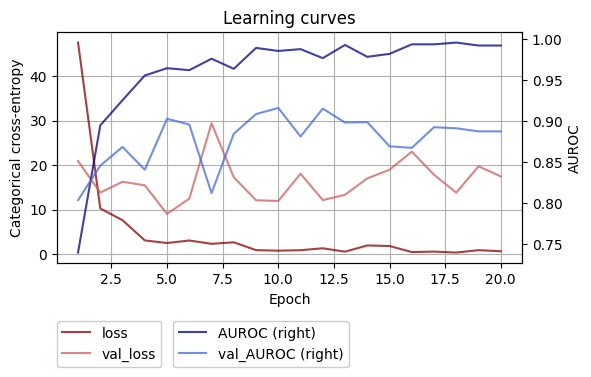

In [11]:
# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"]  #  ["accuracy", "val_accuracy"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("AUROC")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()
     

The plots above indicate that we’re overfitting almost from the start — despite using dropout with a fairly large rate. That’s because this technique doesn’t use data augmentation, which is essential for preventing overfitting with small image datasets.

In [29]:
# Evaluating the model on the test set
test_model = keras.models.load_model("feature_extraction.keras")

result = test_model.evaluate(test_features, test_labels,) 
print(result)

4/4 [==============================] - 0s 6ms/step - loss: 12.7924 - categorical_accuracy: 0.8125 - AUROC: 0.8630
[12.792393684387207, 0.8125, 0.86297607421875]


###1.2 Feature Extraction with Data Augmentation

Now let’s review the second technique for doing feature extraction, which is much slower and more expensive, but which allows us to use data augmentation during training: creating a model that chains the conv_base with a new dense classifier, and training it end to end on the inputs.

In order to do this, we will first freeze the convolutional base. In Keras, we freeze a layer or model by setting its ***trainable*** attribute to ***False***.

In [12]:
# Instantiating and freezing the VGG16 convolutional base
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(128, 128, 3)
    )

conv_base.trainable = False

In [13]:
# Printing the list of trainable weights before and after freezing
conv_base.trainable = True
print("This is the number of trainable weights before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [14]:
conv_base.trainable = False
print("This is the number of trainable weights after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


Now we can create a new model that chains together:
1. A data augmentation stage
2. The frozen convolutional base of pre-trained VGG16
3. A dense classifier

In [15]:
# Defining Augmentation
data_augmentation = Sequential([layers.RandomFlip(), 
                           layers.RandomRotation(factor=0.2), 
                           layers.RandomZoom(height_factor=0.1, width_factor=0.1),
                           layers.RandomContrast(factor=0.3),
                           layers.RandomBrightness(factor=0.3),
                           layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1))])

In [16]:
inputs = keras.Input(shape=(128, 128, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)

model_2 = keras.Model(inputs, outputs)

model_2.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",  
              metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
              metrics.AUC(name='AUROC')])

model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 128, 128, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 128, 128, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                           

Let’s train the model. Thanks to data augmentation, it will take much longer for the model to start overfitting, so we can train for more epochs—let’s do 50.

**NOTE:** This technique is expensive enough that you should only attempt it if you have access to a GPU (such as the free GPU available in Colab)—it’s intractable on CPU.

In [17]:
# turning off warnings for augmentation layer:
# https://stackoverflow.com/questions/73304934/tensorflow-data-augmentation-gives-a-warning-using-a-while-loop-for-converting
tf.get_logger().setLevel('ERROR')


callbacks_2 = [keras.callbacks.ModelCheckpoint(
              filepath="feature_extraction_with_data_augmentation.keras",
              save_best_only=True,
              monitor="val_loss")]


history_2 = model_2.fit(ds_train,
                        epochs=50,
                        validation_data=ds_validation,
                        callbacks=callbacks_2)

Epoch 1/50
17/17 [==============================] - 10s 157ms/step - loss: 66.8450 - categorical_accuracy: 0.5048 - AUROC: 0.6307 - val_loss: 29.3571 - val_categorical_accuracy: 0.6316 - val_AUROC: 0.7322
Epoch 2/50
17/17 [==============================] - 5s 243ms/step - loss: 27.1444 - categorical_accuracy: 0.6335 - AUROC: 0.7300 - val_loss: 21.2570 - val_categorical_accuracy: 0.6917 - val_AUROC: 0.7810
Epoch 3/50
17/17 [==============================] - 3s 133ms/step - loss: 19.8403 - categorical_accuracy: 0.6915 - AUROC: 0.7791 - val_loss: 28.9763 - val_categorical_accuracy: 0.6692 - val_AUROC: 0.7670
Epoch 4/50
17/17 [==============================] - 4s 157ms/step - loss: 18.8449 - categorical_accuracy: 0.7021 - AUROC: 0.7850 - val_loss: 15.3225 - val_categorical_accuracy: 0.7895 - val_AUROC: 0.8470
Epoch 5/50
17/17 [==============================] - 5s 225ms/step - loss: 18.2035 - categorical_accuracy: 0.7060 - AUROC: 0.7888 - val_loss: 22.7260 - val_categorical_accuracy: 0.7444

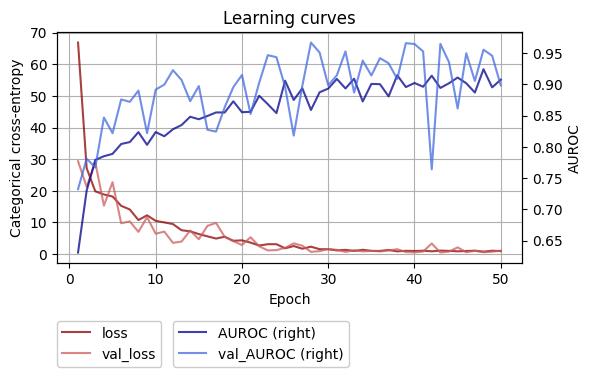

In [19]:
# Plotting out the results
df_hist = pd.DataFrame.from_dict(history_2.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"]  #  ["accuracy", "val_accuracy"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("AUROC")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

In [21]:
# Evaluating the model on the test set
test_model = keras.models.load_model("feature_extraction_with_data_augmentation.keras")

result = test_model.evaluate(ds_test) 
print(result)

2/2 [==============================] - 1s 112ms/step - loss: 0.7579 - categorical_accuracy: 0.8281 - AUROC: 0.9340
[0.7579447031021118, 0.828125, 0.933990478515625]


###1.3.Fine-tuning a pretrained model

Fine-tuning consists of unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in this case, the fully connected classifier) and these top layers.

The steps for fine-tuning a network are as follows:
1. Add the custom network on top of an already-trained base network.
2. Freeze the base network.
3. Train the part we added.
4. Unfreeze some layers in the base network.
5. Jointly train both these layers and the part we added.



We already completed the first three steps when doing feature extraction. Let’s proceed with step 4: we’ll unfreeze our conv_base and then freeze individual layers inside it.

In [22]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

We’ll fine-tune the last three convolutional layers, which means all layers up to block4_pool should be frozen, and the layers block5_conv1, block5_conv2, and block5_conv3 should be trainable.

In [24]:
# Freezing all layers until the fourth from the last
conv_base.trainable = True

for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [25]:
# Fine-tuning the model

model_2.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5), 
              metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
              metrics.AUC(name='AUROC')])

callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="fine_tuning.keras",
    save_best_only=True,
    monitor="val_loss")
]

history_3 = model_2.fit(
    ds_train,
    epochs=30,
    validation_data=ds_validation,
    callbacks=callbacks)

Epoch 1/30
17/17 [==============================] - 7s 181ms/step - loss: 0.6473 - categorical_accuracy: 0.7863 - AUROC: 0.9263 - val_loss: 0.3920 - val_categorical_accuracy: 0.8872 - val_AUROC: 0.9687
Epoch 2/30
17/17 [==============================] - 5s 198ms/step - loss: 0.4551 - categorical_accuracy: 0.8375 - AUROC: 0.9547 - val_loss: 0.6443 - val_categorical_accuracy: 0.8421 - val_AUROC: 0.9522
Epoch 3/30
17/17 [==============================] - 4s 159ms/step - loss: 0.4882 - categorical_accuracy: 0.8182 - AUROC: 0.9490 - val_loss: 0.3889 - val_categorical_accuracy: 0.8571 - val_AUROC: 0.9690
Epoch 4/30
17/17 [==============================] - 4s 148ms/step - loss: 0.4478 - categorical_accuracy: 0.8404 - AUROC: 0.9529 - val_loss: 0.4685 - val_categorical_accuracy: 0.8647 - val_AUROC: 0.9630
Epoch 5/30
17/17 [==============================] - 5s 237ms/step - loss: 0.4437 - categorical_accuracy: 0.8414 - AUROC: 0.9540 - val_loss: 0.4687 - val_categorical_accuracy: 0.8496 - val_AURO

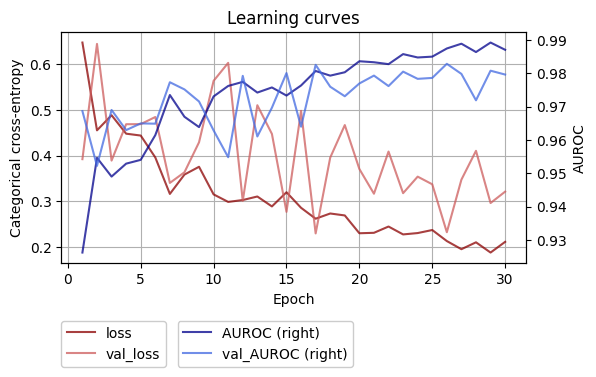

In [26]:
df_hist = pd.DataFrame.from_dict(history_3.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"]  #  ["accuracy", "val_accuracy"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("AUROC")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

In [27]:
# Evaluating the model on the test set
test_model = keras.models.load_model("fine_tuning.keras")

result = test_model.evaluate(ds_test) 
print(result)

2/2 [==============================] - 1s 108ms/step - loss: 0.3839 - categorical_accuracy: 0.8594 - AUROC: 0.9687
[0.3838765621185303, 0.859375, 0.968719482421875]


## Outcomes

In the current notebook, we took an existing convnet available in Keras (in particulat, the convolutional VGG16 network previously trained on ImageNet) and re-used it on the dataset of bean plants via feature extraction. 

We implemented this step in two ways: 
1. Fast Feature Extraction from base without data augmentation.
2. Feature Extraction with data augmentation layer.

Based on the results, even though adding data augmentation step is more computational expensive when extracting features, it seems to be essential for preventing overfitting with small image datasets like we have. 

In addition to Feature Extraction, we also performed Fine Tuning of a pretrained model. As a result, some of the representations previously learned by the VGG16 network were adapted to the classification problem of beans. This pushed the performance of the model even further: the 'categorical_accuracy' after a fine-tuning technique reached the value of 0.8594 on the test (unseen) data, whereas the corresponding 'AUROC' equaled to 0.9687:

|              | categorical_accuracy  | AUROC  |
|:----------------|:----------:| -----:|
| Feature Extraction only | 0.8125 | 0.8630 |
|Feature Extraction with Augmentation | 0.8281 | 0.9340 | 
|Fine-tuning| 0.8594 | 0.9687 |
